# 01 - Préparation et Exploration des Données

Ce notebook effectue la préparation complète des données pour le projet de scoring de crédit.

## Objectifs

1. Chargement et fusion des 8 tables CSV (application, bureau, previous_application, etc.)
2. Nettoyage des données (anomalies, doublons, valeurs manquantes)
3. Feature Engineering (ratios financiers, agrégations multi-niveaux)
4. Encodage des variables catégorielles (Label Encoding + One-Hot)
5. Analyse exploratoire :
   - Déséquilibre des classes
   - Valeurs manquantes
   - Validation de l'intégrité des données
6. Sauvegarde des datasets finaux prêts pour l'entraînement

> Note : Ce notebook utilise la fonction load_and_process_all_data() du module src/data_prep.py qui orchestre la fusion, le nettoyage et l'enrichissement.


In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
import gc
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from data_prep import load_and_process_all_data, missing_values_table

# Configuration d'affichage
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

## 1. Chargement et Fusion des Données

La fonction load_and_process_all_data() effectue automatiquement :
1. Chargement des 8 tables CSV (application_train, application_test, bureau, bureau_balance, previous_application, POS_CASH_balance, installments_payments, credit_card_balance)
2. Nettoyage des anomalies (ex: DAYS_EMPLOYED = 365243 → NaN + flag)
3. Feature Engineering :
   - Création de 4 ratios financiers (CREDIT_INCOME_PERCENT, ANNUITY_INCOME_PERCENT, CREDIT_TERM, DAYS_EMPLOYED_PERCENT)
   - Agrégations multi-niveaux depuis les tables auxiliaires
4. Encodage des variables catégorielles (Label Encoding pour binaires, One-Hot pour les autres)
5. Alignement final des sets Train/Test (même colonnes)


In [1]:
# Configuration du chemin vers les datasets (relatif au dossier notebooks/)
DATASETS_PATH = r'datasets'

print("Démarrage du processus de fusion et enrichissement...")

# Lancement de la fonction maîtresse qui orchestre toutes les étapes
df_train, df_test = load_and_process_all_data(DATASETS_PATH)

# Nettoyage de la mémoire 
gc.collect()

print("\nFusion et enrichissement terminés avec succès !")

Démarrage du processus de fusion et enrichissement...
Cette étape peut prendre plusieurs minutes selon la taille des données.



NameError: name 'load_and_process_all_data' is not defined

## 2. Validation de l'Intégrité des Données

Vérification de la cohérence des jeux de données pour s'assurer qu'il n'y a pas eu de pertes ou duplications inattendues lors des fusions.


In [ ]:
print(f"Shape final du Train : {df_train.shape}")
print(f"Nombre de IDs uniques (Train) : {df_train['SK_ID_CURR'].nunique()}")
print(f"\nShape final du Test : {df_test.shape}")
print(f"Nombre de IDs uniques (Test) : {df_test['SK_ID_CURR'].nunique()}")

# Vérification des colonnes communes 
train_cols = set(df_train.drop(columns=['TARGET', 'SK_ID_CURR']).columns)
test_cols = set(df_test.drop(columns=['SK_ID_CURR']).columns)

print(f"\nNombre de features après FE/Encodage : {len(train_cols)}")

if train_cols == test_cols:
    print("Succès : Les jeux d'entraînement et de test sont alignés.")
else:
    print("Alerte : Les colonnes ne correspondent pas.")
    print(f"Colonnes manquantes dans test : {train_cols - test_cols}")
    print(f"Colonnes en trop dans test : {test_cols - train_cols}")

Shape final du Train : (307511, 1847)
Nombre de IDs uniques (Train) : 307511

Shape final du Test : (48744, 1846)
Nombre de IDs uniques (Test) : 48744

Nombre de features après FE/Encodage : 1845
Succès : Les jeux d'entraînement et de test sont alignés.


## 3. Analyse du Déséquilibre des Classes

La variable cible TARGET indique si le client a eu des difficultés de paiement :
- 0 : Prêt remboursé sans problème
- 1 : Difficultés de paiement (défaut)

Le déséquilibre des classes est un enjeu métier majeur à intégrer dans la construction du modèle.


Distribution de la variable TARGET :

Classe     Nombre          Pourcentage    
----------------------------------------
0          282686          91.93%
1          24825           8.07%

Le dataset est fortement déséquilibré :
   - Classe majoritaire (0) : 91.93%
   - Classe minoritaire (1) : 8.07%
   - Ratio : 11.4:1


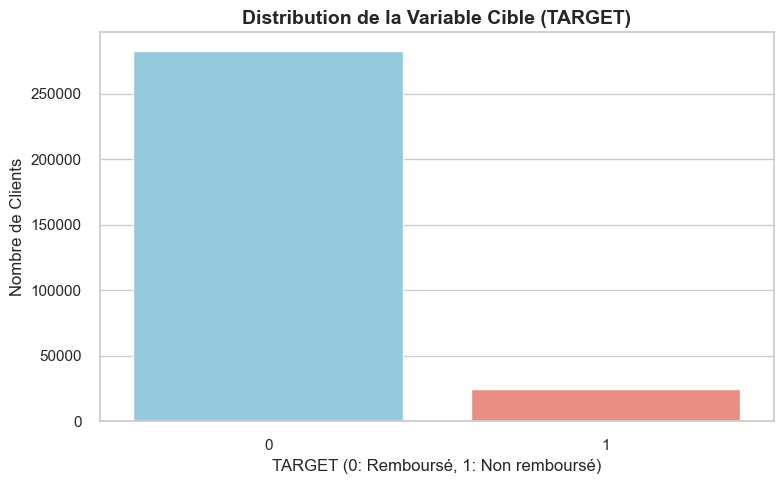

In [ ]:
target_counts = df_train['TARGET'].value_counts()
target_percentages = df_train['TARGET'].value_counts(normalize=True) * 100

print("Distribution de la variable TARGET :")
print(f"\n{'Classe':<10} {'Nombre':<15} {'Pourcentage':<15}")
print("-" * 40)
for idx in [0, 1]:
    print(f"{idx:<10} {target_counts[idx]:<15} {target_percentages[idx]:.2f}%")

print(f"\nLe dataset est fortement déséquilibré :")
print(f"   - Classe majoritaire (0) : {target_percentages[0]:.2f}%")
print(f"   - Classe minoritaire (1) : {target_percentages[1]:.2f}%")
print(f"   - Ratio : {target_counts[0] / target_counts[1]:.1f}:1")

fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df_train, x='TARGET', palette=['skyblue', 'salmon'], ax=ax)
ax.set_title('Distribution de la Variable Cible (TARGET)', fontsize=14, fontweight='bold')
ax.set_xlabel('TARGET (0: Remboursé, 1: Non remboursé)', fontsize=12)
ax.set_ylabel('Nombre de Clients', fontsize=12)


plt.tight_layout()
plt.show()

### Implications du déséquilibre

Le dataset est fortement déséquilibré (~92% de classe 0, ~8% de classe 1). Cela nécessite :

1. Techniques d'entraînement adaptées :
   - Utilisation de class_weight='balanced' dans les modèles
   - Métriques adaptées (F1-score, AUC-ROC, coût métier)
   - Optimisation du seuil de décision (pas 0.5 par défaut)

2. Métrique métier :
   - Le coût d'un Faux Négatif (FN) est 10× plus élevé qu'un Faux Positif (FP)
   - Il faut minimiser les FN (ne pas manquer les vrais défauts)


## 4. Analyse des Valeurs Manquantes

Analyse de l'étendue des valeurs manquantes introduites par le processus d'enrichissement (agrégations depuis les tables auxiliaires).


In [27]:
missing_table = missing_values_table(df_train)

print(f"Colonnes avec des valeurs manquantes : {len(missing_table)} sur {len(df_train.columns)}")
print(f"\nTop 20 des colonnes avec le plus de valeurs manquantes :\n")
print(missing_table.head(20).to_string())

# Résumé statistique
if len(missing_table) > 0:
    print(f"\nStatistiques sur les valeurs manquantes :")
    print(f"   - Pourcentage moyen : {missing_table['% of Total Values'].mean():.2f}%")
    print(f"   - Pourcentage maximum : {missing_table['% of Total Values'].max():.2f}%")
    print(f"   - Colonnes avec >50% de valeurs manquantes : {(missing_table['% of Total Values'] > 50).sum()}")

Colonnes avec des valeurs manquantes : 1667 sur 1847

Top 20 des colonnes avec le plus de valeurs manquantes :

                                                          Missing Values  % of Total Values
prev_agg_RATE_INTEREST_PRIMARY_mean                               302902               98.5
prev_agg_RATE_INTEREST_PRIMARY_max                                302902               98.5
prev_agg_RATE_INTEREST_PRIVILEGED_min                             302902               98.5
prev_agg_RATE_INTEREST_PRIMARY_min                                302902               98.5
prev_agg_RATE_INTEREST_PRIVILEGED_mean                            302902               98.5
prev_agg_RATE_INTEREST_PRIVILEGED_max                             302902               98.5
client_credit_credit_AMT_PAYMENT_CURRENT_max_mean                 246451               80.1
client_credit_credit_AMT_PAYMENT_CURRENT_mean_min                 246451               80.1
client_credit_credit_AMT_PAYMENT_CURRENT_mean_max           

### Stratégie d'Imputation

De nombreuses *features* agrégées (issues des fusions avec des tables peu remplies pour certains clients) présentent un taux élevé de valeurs manquantes.

Stratégie : Nous ne procédons à aucune imputation pour l'instant.

Justification : L'utilisation de modèles tree-based (comme LightGBM ou XGBoost) est prévue. Ces algorithmes gèrent nativement les `NaN` et peuvent les utiliser comme un indicateur de l'absence d'historique. Cela permet de préserver l'information et répond à l'exigence d'éviter d'imputer sans documenter ni justifier.


## 5. Validation des Features Créées

Vérification de la création et de la corrélation des *features* de *Domain Knowledge* (Feature Engineering manuel) créées à partir de la table application.


In [28]:
# Identifier les features créées manuellement
new_features_ratios = [
    'CREDIT_INCOME_PERCENT', 
    'ANNUITY_INCOME_PERCENT', 
    'CREDIT_TERM', 
    'DAYS_EMPLOYED_PERCENT',
    'DAYS_EMPLOYED_ANOM'  
]

# Vérifier qu'elles existent et calculer les corrélations avec TARGET
existing_ratios = [f for f in new_features_ratios if f in df_train.columns]

if existing_ratios:
    correlation_df = df_train[existing_ratios + ['TARGET']].copy()
    correlation_ratios = correlation_df.corr().sort_values('TARGET', ascending=False)
    
    print("Corrélations des features de ratios avec TARGET :")
    print(correlation_ratios['TARGET'].drop('TARGET').to_string())
    
    print(f"\n{len(existing_ratios)} features de ratios créées avec succès")
else:
    print("Aucune feature de ratio trouvée") 

Corrélations des features de ratios avec TARGET :
DAYS_EMPLOYED_PERCENT     0.067955
ANNUITY_INCOME_PERCENT    0.014265
CREDIT_TERM               0.012704
CREDIT_INCOME_PERCENT    -0.007727
DAYS_EMPLOYED_ANOM       -0.045987

5 features de ratios créées avec succès


### Conclusion sur les Ratios

Les ratios ont des corrélations faibles à modérées avec TARGET. Ces corrélations sont souvent plus fortes que celles de nombreuses *features* initiales et justifient leur conservation et leur évaluation par le modèle.



## 6. Aperçu du Dataset Final

Affichage d'un aperçu du dataset enrichi pour validation.


In [31]:
df_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION

In [30]:
df_train.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION

## 7. Sauvegarde des Datasets Finaux

Sauvegarde des datasets enrichis et alignés dans le dossier `datasets/final/` pour utilisation dans les notebooks suivants.


In [ ]:
os.makedirs('../datasets/final', exist_ok=True)

df_train_final, df_sample = train_test_split(
    df_train,
    test_size=10000,     
    random_state=42,     
    stratify=df_train['TARGET']
)

sample_ids = df_sample['SK_ID_CURR']
sample_labels = df_sample['TARGET']
sample_features = df_sample.drop(columns=['SK_ID_CURR', 'TARGET'])

# Sauvegarde du sample
sample_features.to_csv('../datasets/final/test_sample_features.csv', index=False)
sample_labels.to_csv('../datasets/final/test_sample_labels.csv', index=False)
sample_ids.to_csv('../datasets/final/test_sample_ids.csv', index=False)

print(f"Sample de test créé : {sample_features.shape}")

# Séparer les IDs et labels avant la sauvegarde
train_ids = df_train_final['SK_ID_CURR']
train_labels = df_train_final['TARGET']
df_train_final = df_train_final.drop(columns=['SK_ID_CURR', 'TARGET'])

test_ids = df_test['SK_ID_CURR']
df_test_final = df_test.drop(columns=['SK_ID_CURR'])

# Sauvegarde des datasets enrichis 
df_train_final.to_csv('../datasets/final/train_enriched.csv', index=False)
df_test_final.to_csv('../datasets/final/test_enriched.csv', index=False)

# Sauvegarde des IDs et labels séparément pour la gestion du pipeline MLOps
train_labels.to_csv('../datasets/final/train_labels.csv', index=False, header=True)
train_ids.to_csv('../datasets/final/train_ids.csv', index=False, header=True)
test_ids.to_csv('../datasets/final/test_ids.csv', index=False, header=True)

print("Datasets enrichis et alignés sauvegardés dans 'datasets/final/' :")
print("- train_enriched.csv : Features d'entraînement")
print("- test_enriched.csv : Features de test")
print("- train_labels.csv : Labels d'entraînement (TARGET)")
print("- train_ids.csv : IDs d'entraînement (SK_ID_CURR)")
print("- test_ids.csv : IDs de test (SK_ID_CURR)")

print("\nRésumé final :")
print(f"- Features : {df_train_final.shape[1]} colonnes")
print(f"- Échantillons train : {df_train_final.shape[0]}")
print(f"- Échantillons test : {df_test_final.shape[0]}")


Sample de test créé : (10000, 1845)
Datasets enrichis et alignés sauvegardés dans 'datasets/final/' :
   - train_enriched.csv : Features d'entraînement
   - test_enriched.csv : Features de test
   - train_labels.csv : Labels d'entraînement (TARGET)
   - train_ids.csv : IDs d'entraînement (SK_ID_CURR)
   - test_ids.csv : IDs de test (SK_ID_CURR)

Résumé final :
   - Features : 1845 colonnes
   - Échantillons train : 297511
   - Échantillons test : 48744
